In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('insurance.csv')
print("Данные загружены. Размер:", data.shape)
print("Первые 5 строк:")
print(data.head())

Данные загружены. Размер: (1338, 7)
Первые 5 строк:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [2]:
missing_data = data.isnull().sum()
print("Пропуски по колонкам:")
for col, missing_count in missing_data.items():
    print(f"  {col}: {missing_count} пропусков")

if missing_data.sum() == 0:
    print("✓ Пропусков в данных нет")
else:
    print(f"⚠ Обнаружено пропусков: {missing_data.sum()}")


def detect_outliers(series):
    """Обнаружение выбросов с помощью метода IQR"""
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = series[(series < lower_bound) | (series > upper_bound)]
    return outliers, lower_bound, upper_bound

print("Выбросы в численных признаках:")
numerical_cols = ['age', 'bmi', 'children', 'charges']

for col in numerical_cols:
    outliers, lower, upper = detect_outliers(data[col])
    print(f"{col.upper()}:  Выбросов: {len(outliers)}  Процент выбросов: {len(outliers)/len(data)*100:.1f}%")

Пропуски по колонкам:
  age: 0 пропусков
  sex: 0 пропусков
  bmi: 0 пропусков
  children: 0 пропусков
  smoker: 0 пропусков
  region: 0 пропусков
  charges: 0 пропусков
✓ Пропусков в данных нет
Выбросы в численных признаках:
AGE:  Выбросов: 0  Процент выбросов: 0.0%
BMI:  Выбросов: 9  Процент выбросов: 0.7%
CHILDREN:  Выбросов: 0  Процент выбросов: 0.0%
CHARGES:  Выбросов: 139  Процент выбросов: 10.4%


In [17]:
data_encoded = data.copy()

data_encoded['sex'] = data_encoded['sex'].map({'female': 1, 'male': 0})
data_encoded['smoker'] = data_encoded['smoker'].map({'no': 0, 'yes': 1})

region_dummies = pd.get_dummies(data_encoded['region'], prefix='region')

data_encoded = data_encoded.drop('region', axis=1)
data_encoded = pd.concat([data_encoded, region_dummies], axis=1)

print(data_encoded.head(10))

   age  sex     bmi  children  smoker      charges  region_northeast  \
0   19    1  27.900         0       1  16884.92400             False   
1   18    0  33.770         1       0   1725.55230             False   
2   28    0  33.000         3       0   4449.46200             False   
3   33    0  22.705         0       0  21984.47061             False   
4   32    0  28.880         0       0   3866.85520             False   
5   31    1  25.740         0       0   3756.62160             False   
6   46    1  33.440         1       0   8240.58960             False   
7   37    1  27.740         3       0   7281.50560             False   
8   37    0  29.830         2       0   6406.41070              True   
9   60    1  25.840         0       0  28923.13692             False   

   region_northwest  region_southeast  region_southwest  
0             False             False              True  
1             False              True             False  
2             False              

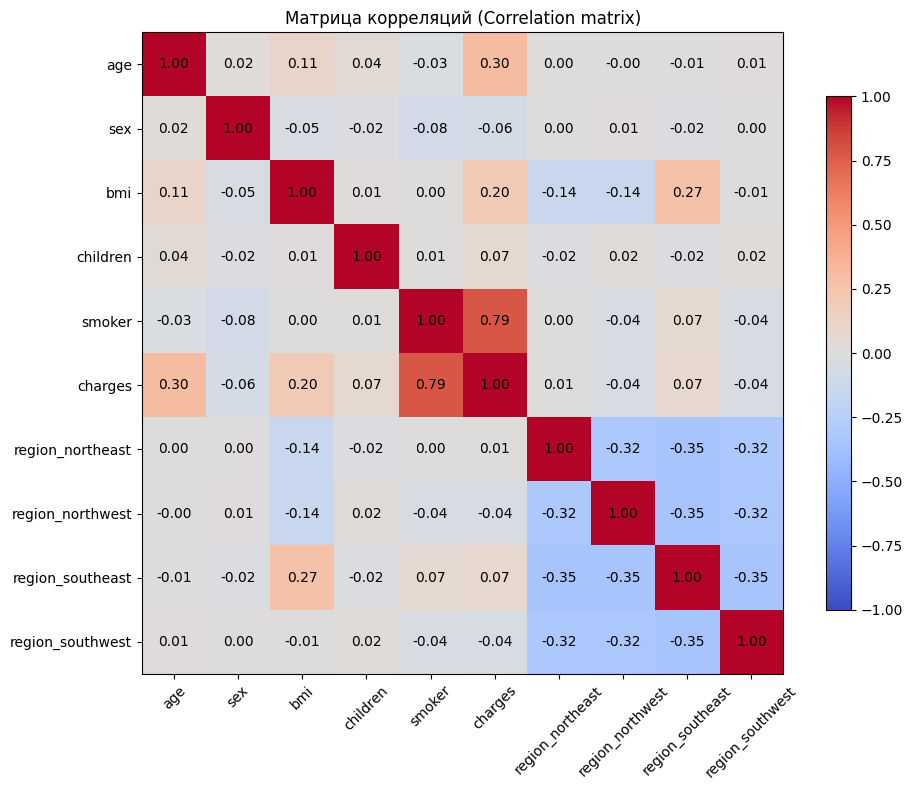

In [18]:
correlation_matrix = data_encoded.corr()


# Визуализация матрицы корреляций
plt.figure(figsize=(10, 8))

# Создаем heatmap с помощью imshow (аналог seaborn heatmap)
im = plt.imshow(correlation_matrix.values, cmap='coolwarm', vmin=-1, vmax=1)

# Добавляем подписи
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

# Добавляем значения корреляций в ячейки
for i in range(len(correlation_matrix.columns)):
    for j in range(len(correlation_matrix.columns)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)

# Добавляем colorbar
plt.colorbar(im, shrink=0.8)
plt.title('Матрица корреляций (Correlation matrix)')
plt.tight_layout()
plt.show()

In [19]:
RANDOM_STATE = 42

data_fixed = data_encoded.copy()
data_fixed = data_fixed.drop('region_southwest', axis=1)  # убираем одну колонку региона

# Преобразуем в float
for col in data_fixed.columns:
    data_fixed[col] = data_fixed[col].astype(float)

# Подготовка данных
y = data_fixed['charges'].values.reshape(-1, 1)
X = data_fixed.drop(columns=['charges']).values
feature_names = data_fixed.drop(columns=['charges']).columns.tolist()

# Разделение на train/test
np.random.seed(RANDOM_STATE)
n = len(X)
n_test = int(n * 0.2)
indices = np.random.permutation(n)
test_idx = indices[:n_test]
train_idx = indices[n_test:]
X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Добавляем intercept
X_train_const = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test_const = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

# Аналитическое решение
def normal_equation(X, y):
    XtX = X.T @ X
    Xty = X.T @ y
    theta = np.linalg.pinv(XtX) @ Xty
    return theta

theta_analytic = normal_equation(X_train_const, y_train)

# Предсказания
y_pred_train = X_train_const @ theta_analytic
y_pred_test = X_test_const @ theta_analytic

# Метрики
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Вывод результатов
print("ПАРАМЕТРЫ МОДЕЛИ:")
feature_names_with_intercept = ['intercept'] + feature_names
for name, weight in zip(feature_names_with_intercept, theta_analytic.flatten()):
    print(f"{name:15} : {weight:10.2f}")

print(f"\nМЕТРИКИ:")
print(f"MSE: {mse_test:,.2f}")
print(f"R²:  {r2_test:.4f}")

ПАРАМЕТРЫ МОДЕЛИ:
intercept       :  -12756.22
age             :     256.86
sex             :      14.14
bmi             :     336.88
children        :     425.48
smoker          :   23653.02
region_northeast :     818.41
region_northwest :     447.89
region_southeast :     161.42

МЕТРИКИ:
MSE: 33,699,820.61
R²:  0.7837


In [20]:
def standard_scale(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std == 0] = 1
    return (X - mean) / std, mean, std

X_train_scaled, mean, std = standard_scale(X_train_const[:, 1:])
X_test_scaled = (X_test_const[:, 1:] - mean) / std

X_train_gd = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test_gd = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])

# Градиентный спуск с масштабированными данными
def gradient_descent(X, y, learning_rate=0.1, iterations=1000):
    m = len(y)
    theta = np.zeros((X.shape[1], 1))
    cost_history = []
    
    for i in range(iterations):
        predictions = X @ theta
        errors = predictions - y
        gradient = (1/m) * X.T @ errors
        theta -= learning_rate * gradient
        
        if i % 200 == 0:
            cost = (1/(2*m)) * np.sum(errors**2)
            cost_history.append(cost)
    
    return theta, cost_history

# Обучение
theta_gd, cost_history = gradient_descent(X_train_gd, y_train, learning_rate=0.1, iterations=1000)

# Предсказания и метрики
y_pred_test_gd = X_test_gd @ theta_gd
mse_test_gd = mean_squared_error(y_test, y_pred_test_gd)
r2_test_gd = r2_score(y_test, y_pred_test_gd)

print("ПАРАМЕТРЫ МОДЕЛИ (градиентный спуск):")
for name, weight in zip(feature_names_with_intercept, theta_gd.flatten()):
    print(f"{name:15} : {weight:10.2f}")

print(f"\nМЕТРИКИ:")
print(f"MSE: {mse_test_gd:,.2f}")
print(f"R²:  {r2_test_gd:.4f}")

print(f"\nСРАВНЕНИЕ:")
print(f"{'Метод':20} | {'MSE':>12} | {'R²':>6}")
print(f"{'Аналитический':20} | {mse_test:12,.0f} | {r2_test:6.4f}")
print(f"{'Градиентный спуск':20} | {mse_test_gd:12,.0f} | {r2_test_gd:6.4f}")

ПАРАМЕТРЫ МОДЕЛИ (градиентный спуск):
intercept       :   13342.85
age             :    3612.84
sex             :       7.07
bmi             :    2034.36
children        :     516.89
smoker          :    9555.94
region_northeast :     354.05
region_northwest :     191.02
region_southeast :      71.17

МЕТРИКИ:
MSE: 33,699,820.61
R²:  0.7837

СРАВНЕНИЕ:
Метод                |          MSE |     R²
Аналитический        |   33,699,821 | 0.7837
Градиентный спуск    |   33,699,821 | 0.7837


In [7]:
def ridge_analytical(X, y, alpha=1.0):
    XtX = X.T @ X
    n_features = XtX.shape[0]
    
    I = np.eye(n_features)
    I[0, 0] = 0
    
    XtX_ridge = XtX + alpha * I
    Xty = X.T @ y
    theta = np.linalg.pinv(XtX_ridge) @ Xty
    return theta

alphas = [0.1, 1.0, 10.0, 100.0]

print("Ridge регрессия (аналитическая):")
print(f"{'Alpha':>8} | {'MSE':>12} | {'R²':>8}")
print("-" * 35)

for alpha in alphas:
    theta_ridge = ridge_analytical(X_train_const, y_train, alpha=alpha)
    y_pred_ridge = X_test_const @ theta_ridge
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    
    print(f"{alpha:8.1f} | {mse_ridge:12,.0f} | {r2_ridge:8.4f}")

Ridge регрессия (аналитическая):
   Alpha |          MSE |       R²
-----------------------------------
     0.1 |   33,704,172 |   0.7837
     1.0 |   33,745,757 |   0.7834
    10.0 |   34,374,929 |   0.7794
   100.0 |   48,399,641 |   0.6893


In [21]:
def gradient_descent_ridge(X, y, alpha=1.0, learning_rate=0.1, iterations=1000):
    m = len(y)
    theta = np.zeros((X.shape[1], 1))
    
    for i in range(iterations):
        predictions = X @ theta
        errors = predictions - y
        gradient = (1/m) * X.T @ errors
        gradient[1:] += (alpha/m) * theta[1:]
        theta -= learning_rate * gradient
    
    return theta

print("Ridge регрессия (градиентный спуск):")
print(f"{'Alpha':>8} | {'MSE':>12} | {'R²':>8}")
print("-" * 35)

for alpha in alphas:
    theta_ridge = gradient_descent_ridge(X_train_gd, y_train, alpha=alpha)
    y_pred_ridge = X_test_gd @ theta_ridge
    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)
    
    print(f"{alpha:8.1f} | {mse_ridge:12,.0f} | {r2_ridge:8.4f}")

Ridge регрессия (градиентный спуск):
   Alpha |          MSE |       R²
-----------------------------------
     0.1 |   33,700,581 |   0.7837
     1.0 |   33,707,516 |   0.7836
    10.0 |   33,785,293 |   0.7831
   100.0 |   35,257,250 |   0.7737


In [22]:
y_pred_const = np.full_like(y_test, np.mean(y_train))
mse_const = mean_squared_error(y_test, y_pred_const)

mse_analytical = mse_test
mse_gd = mse_test_gd

# 3. Модели из пункта 3 (alpha=1.0)
theta_ridge_anal = ridge_analytical(X_train_const, y_train, alpha=1.0)
y_pred_ridge_anal = X_test_const @ theta_ridge_anal
mse_ridge_anal = mean_squared_error(y_test, y_pred_ridge_anal)

theta_ridge_gd = gradient_descent_ridge(X_train_gd, y_train, alpha=1.0)
y_pred_ridge_gd = X_test_gd @ theta_ridge_gd
mse_ridge_gd = mean_squared_error(y_test, y_pred_ridge_gd)

# Сравнение
print("СРАВНЕНИЕ МОДЕЛЕЙ ПО MSE:")
print(f"{'Модель':25} | {'MSE':>15}")
print("-" * 45)
print(f"{'Константная':25} | {mse_const:15,.0f}")
print(f"{'Линейная (аналит.)':25} | {mse_analytical:15,.0f}")
print(f"{'Линейная (GD)':25} | {mse_gd:15,.0f}")
print(f"{'Ridge α=1.0 (аналит.)':25} | {mse_ridge_anal:15,.0f}")
print(f"{'Ridge α=1.0 (GD)':25} | {mse_ridge_gd:15,.0f}")

СРАВНЕНИЕ МОДЕЛЕЙ ПО MSE:
Модель                    |             MSE
---------------------------------------------
Константная               |     155,925,884
Линейная (аналит.)        |      33,699,821
Линейная (GD)             |      33,699,821
Ridge α=1.0 (аналит.)     |      33,745,757
Ridge α=1.0 (GD)          |      33,707,516
